# QAOA Result Viewer

## Import libraries

In [2]:
# system
import os
import json

# network
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# utils
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#qiskit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit_aer import AerSimulator

#patoka
from patoka import processJobData, retrieveJobData, getResultViewer

## Sign in to IBMQ

In [2]:
token = os.environ["ibm_token"]
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

## Define a graph

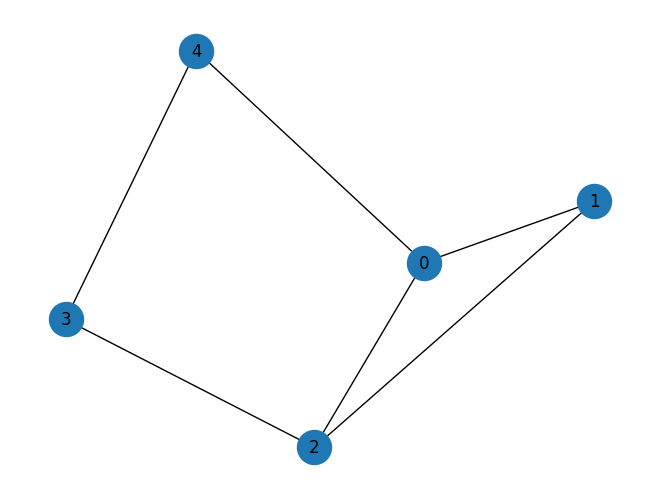

In [3]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

### Get Pauli expressions of the graph

In [4]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### Draw a circuit based on the Pauli expression

In [5]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw()

┌────────────────────────────┐ ░ ┌─┐            
   q_0: ┤0                           ├─░─┤M├────────────
        │                            │ ░ └╥┘┌─┐         
   q_1: ┤1                           ├─░──╫─┤M├─────────
        │                            │ ░  ║ └╥┘┌─┐      
   q_2: ┤2 QAOA(γ[0],β[0],γ[1],β[1]) ├─░──╫──╫─┤M├──────
        │                            │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤3                           ├─░──╫──╫──╫─┤M├───
        │                            │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤4                           ├─░──╫──╫──╫──╫─┤M├
        └────────────────────────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════════════╩══╩══╩══╩══╩═
                                          0  1  2  3  4

### Get a backend machine and optimize the circuit initially

In [6]:
backend = service.least_busy(min_num_qubits=127)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)

### Obtain parameters

Fist sest some initial parameters and run the estimator a few times via scipy optimizer

In [7]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_record):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_record.append(cost)


    return cost

# this was the final parameter for the circuit
# final_params = [3.37261987, 2.89704639, 2.79501949, 0.86452671]

In [8]:
# using the Aer Simulator for the initial estimation
backend_aer = AerSimulator()

objective_func_vals = [] # Global variable
with Session(backend=backend_aer) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator, objective_func_vals),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/Users/hyeokkim/nosync/patoka/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Users/hyeokkim/nosync/patoka/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Users/hyeokkim/nosync/patoka/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates'

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.60939060939061
       x: [ 3.373e+00  2.897e+00  2.795e+00  8.645e-01]
    nfev: 37
   maxcv: 0.0


/Users/hyeokkim/nosync/patoka/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Users/hyeokkim/nosync/patoka/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Users/hyeokkim/nosync/patoka/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates'

#### Plotting the optmiization outcome

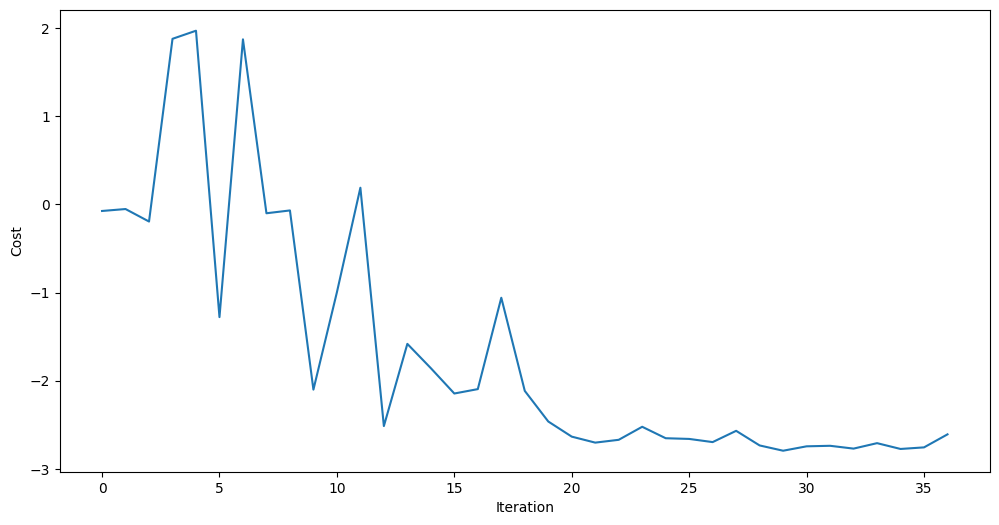

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

#### Assign the final optimized parameter to the transpiled circuit

In [10]:
final_params = result.x
optimized_circuit = candidate_circuit.assign_parameters(final_params)
final_params

array([3.37261987, 2.89704639, 2.79501949, 0.86452671])

## Run the sampler to the final outcome

In [13]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 4000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit, )
# uncomment the below line to run the job
# job = sampler.run([pub], shots=4000)

### Retrieve the job data and save it.

In [ ]:
# retrieve the job (check the id from your IBMQ dashboard)
job_id = ""
job_data = processJobData(service, job_id, circuit)

# pass additional information so that the result viewer have the relevant information
job_data.setAdditionalData("hamiltonian", cost_hamiltonian.to_list())
job_data.setAdditionalData("graph_design", rx.node_link_json(graph))
job_data.setAdditionalData("final_params", final_params)

with open("qaoa_job_data.json", "w") as f:
    f.write(job_data.toJSON())

## Generate Hypothetical Error-adjustment outcome

The below box should be run with caution. It took 3 hours and 21 minutes for 10,000 times simulation with 4,000 shots and 177 layers. 

In [ ]:
sim_job = job_data.generate_hea()

with open("qaoa_job_data_hea.json", "w") as f:
    f.write(job_data.toJSON())

In [3]:
data2 = None
with open("qaoa_job_data_hea.json", "r") as f:
    data2 = retrieveJobData(json.load(f))

QASM3 parsing failed


In [4]:
viewer = getResultViewer()
viewer

ResultViewer(data='{}')

In [5]:
data2.streamJSON(viewer)

passing basic data
passing counts data 0~
Complete passing counts data
passing uncertainty data data
passing uncertainty data counts
passing uncertainty data probs
passing uncertainty data sim_error
passing uncertainty data mean_sim_error
passing uncertainty data metadata
Complete passing uncertainty data
passing original circuit layout data 0~
Complete passing original circuit layout upto 7
passing transpiled circuit layout data 0~
Complete passing transpiled circuit layout upto 178
Complete passing additional data
